In [1]:
library(ggplot2)
library(dplyr)
library(stringr)
library(forecast)
library(LaplacesDemon)
library(reshape)
library(gsynth)
library(readxl)
library(reshape)
library(lubridate)
library(zoo)
library(MASS)
library(doParallel)

library(foreach)
library(forecast)

options(dplyr.summarise.inform = FALSE)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘LaplacesDemon’


The following object is masked from ‘package:forecast’:

    is.constant



Attaching package: ‘reshape’


The following object is masked from ‘package:dplyr’:

    rename


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘lubridate’


The following object is masked from ‘package:reshape’:

    stamp


The following objects are masked from ‘package:LaplacesDemon’:

    dst, interval


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching pac

In [2]:
variableExpander <- function(keysAndVariable, unitKey, timeKey){ ### Expands into unit/time format
  
  orderedData <- keysAndVariable %>% arrange(get(unitKey), get(timeKey))
  
  outcomeName <- names(keysAndVariable)[!(names(keysAndVariable) %in% c(unitKey, timeKey))]
  
  outcomeMatrixForm <- matrix(NA, nrow=length(unique(keysAndVariable[, unitKey])), 
                              ncol=length(unique(keysAndVariable[, timeKey])), byrow=T)
  
  rownames(outcomeMatrixForm) <- unique(keysAndVariable[, unitKey])
  
  colnames(outcomeMatrixForm) <- str_replace_all(unique(keysAndVariable[, timeKey])[order(unique(keysAndVariable[, timeKey]))], pattern="-", replace="")
  
  for (index in 1:length(keysAndVariable[, unitKey])){
    
    outcomeMatrixForm[keysAndVariable[, unitKey][index], str_replace_all(keysAndVariable[, timeKey][index], pattern="-", replace="")] <- keysAndVariable[, outcomeName][index]
    
  }
  
  return(outcomeMatrixForm)
  
}


makeFilename <- function(directory, fileName){
    
    paste(directory, fileName, sep='/')
}

In [3]:
source('../weighted_matrix_estimation_methodologies.R')

Loading required package: Matrix


Attaching package: ‘Matrix’


The following object is masked from ‘package:reshape’:

    expand


Loaded glmnet 3.0-2




In [4]:
list.files()

[1] "Assess Effect of Michael Leaving.ipynb"   
[2] "Assess Effect of Michael Leaving.R"       
[3] "big tv rating data.csv"                   
[4] "IMDb Rating Cleaning.ipynb"               
[5] "Office Ratings (with Michael Leaving).pdf"
[6] "plotsAndTables"                           
[7] "Synthetic Music Data Generator.ipynb"     
[8] "tv rating data.csv"                       
[9] "vTuber Data Analysis"

In [5]:
max_available_clusters <- detectCores()-1
  
desired_clusters <- 4
  
cl <- makeCluster(min(c(max_available_clusters, desired_clusters)))

registerDoParallel(cl)

In [6]:
officeCode <- 'tt0386676'

In [7]:
tvData = read.csv("big tv rating data.csv")

orderedTvData <- tvData %>% arrange(Title, Episode.Number)

orderedTvData <- orderedTvData %>% mutate(
    condensedNumber=rep(1:50, length(unique(tvData$Code))))

In [8]:
Y <- variableExpander(orderedTvData[, c('Title', 'condensedNumber', 'smoothedRating')],
                unitKey='Title', timeKey='condensedNumber')


D <- variableExpander(orderedTvData[, c('Title', 'condensedNumber', 'main_character_left')],
                unitKey='Title', timeKey='condensedNumber')

In [14]:
#chosenSeries <- orderedTvData %>% filter(Title %in% c("Avatar: The Last Airbender", "The Legend of Korra",
#    "The X Files", "Samurai Jack", "Community", "The Office"))

chosenSeries <- orderedTvData %>% filter(Title %in% c("The Office", "Community", 
                                                      "Parks and Recreation", "Superstore",
                                                     "The Mindy Project",
                                                     "Psych"))

panelDataExample <- ggplot(chosenSeries, aes(x=condensedNumber, y=smoothedRating, col=Title)) + geom_line(lwd=1.25)  +
 theme_bw(base_size=20) + 
facet_wrap(~Title, scales='free') + xlab("Time") + ylab('Smoothed Rating')+
ggtitle("Ratings for Comedies on IMDb") + guides(col=FALSE)

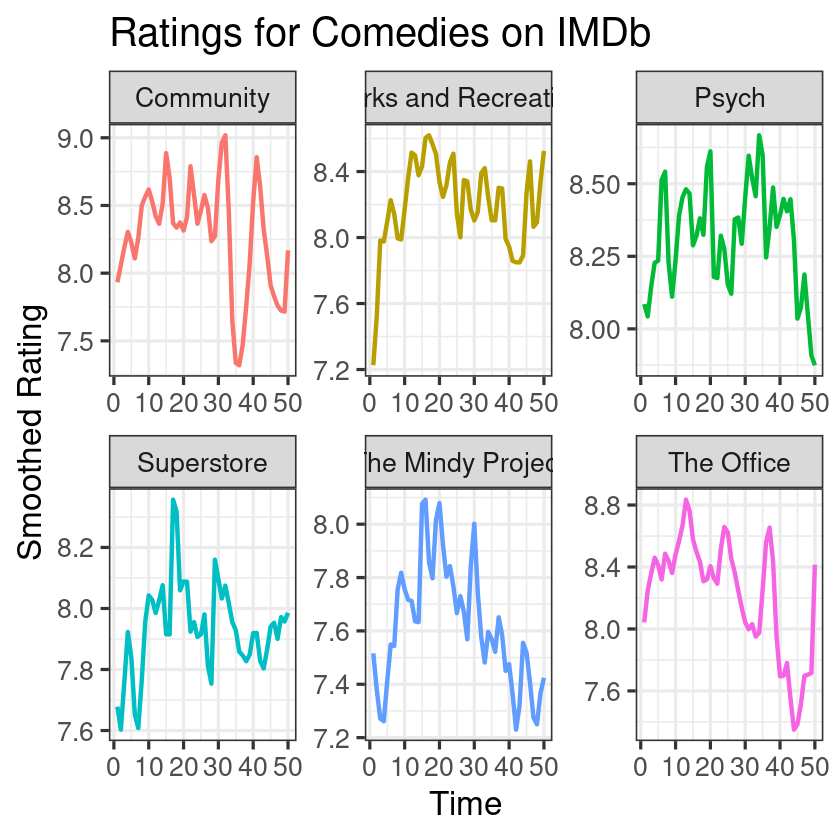

In [15]:
panelDataExample 

# Method Performance Assessment

In [11]:
TvCovariate <- orderedTvData %>% group_by(Title) %>% summarize(mean_rating = mean(Rating))

In [12]:
goodPoints <- which(colSums(D)==0)

numberOfPointsToBLockOut <- min(13, max(rowSums(D)))

allNonMissingY <- Y[, goodPoints]

print(paste("Number of shows:", dim(Y)[1]))

[1] "Number of shows: 691"


In [13]:
covariates <- TvCovariate["mean_rating"]

In [14]:
#truehist(as.numeric(as.matrix(covariates)))

In [15]:
### Change the magnitude of scoreBeta to affect the distribution of the probability of being treated
scoreBeta <- c(-.07)

In [16]:
Time0 <- 30

simulatedTreatmentData <- parameterMakerBlockProvidedCovariates(
    Time=dim(allNonMissingY)[2],
         modelCovariates=as.matrix(covariates), Time0=Time0, propTreat=.1,
                                     glmBeta=scoreBeta)

In [17]:
observedData <- allNonMissingY * (1-simulatedTreatmentData$W)

In [18]:
treatProfile <- colMeans(observedData[which(rowSums(simulatedTreatmentData$W) > 0),])
untreatProfile <- colMeans(observedData[which(rowSums(simulatedTreatmentData$W) == 0),])

In [19]:
neededTimes <- as.numeric(names(untreatProfile))


averageUnitData <- cbind.data.frame(rep(neededTimes, 2), 
        c(unname(treatProfile), unname(untreatProfile)), rep(c('Treated', 'Untreated'), 
                                                             each=length(neededTimes)))

names(averageUnitData) <- c('Time', 'Average Rating', 'Unit Type')

groupComparisonPlot <- ggplot(averageUnitData %>% filter(Time >= 1 & Time <= 30), 
       aes(x=Time, y=`Average Rating`, col=`Unit Type`)) +
 geom_line(lwd=2) + 
theme_bw(base_size=20) + geom_vline(xintercept = averageUnitData$Time[Time0], lwd=1.5) +
ggtitle("Aggregated TV Ratings")




In [20]:
dataForCalculatingGroupDiff <- (averageUnitData %>% filter(Time <= 30) %>% group_by(`Unit Type`) %>% 
                                summarize(mean_rating=mean(`Average Rating`)))

In [21]:
# dim(allNonMissingY)[1]

#c(-.01, -.1, -.5, -1, -2, -3)

#  2*c(-.01, -.1, -.5, -1, -2, -3)

# c(-1, -2, -3, -6, -7.5)

betaSizes <- c(-1, -2, -3, -6, -7.5)

In [22]:
options(warn=-1)

In [578]:
set.seed(529371)

numSims <- 50

chosenLength <- NULL

#rateOfDecay <- .2
#finalProp <- .6
#Time0 <- 90

Time0 <- 30

methodNames <- c('MC-NNM', "Weighted softImpute", 'FACTOR', 'R1Comp', 'Weighted R1Comp')

effects <- array(NA, dim=c(5, numSims, length(betaSizes)), dimnames=list(methodNames,
                                                                           paste('iteration', 1:numSims, sep='_'),
                                                                             betaSizes))
        
forecastMSES <- array(NA, dim=c(5, numSims, length(betaSizes)), dimnames=list(methodNames,
                                                                           paste('iteration', 1:numSims, sep='_'),
                                                                             betaSizes))

aveGroupDiffs <- rep(NA, length(betaSizes))

names(aveGroupDiffs) <- betaSizes

for (scoreBeta in betaSizes){
    
    scoreBetaForIndex <- as.character(scoreBeta)
    
    aveGroupDiffsPerIteration <- rep(NA, numSims)


    for (simNumber in 1:numSims){



        simulatedTreatmentData <- parameterMakerBlockProvidedCovariates(Time=dim(allNonMissingY)[2],
                                                                    modelCovariates=as.matrix(covariates),
                                                                        Time0=Time0, propTreat=.3,
                                         glmBeta=scoreBeta)

        observedData <- allNonMissingY * (1-simulatedTreatmentData$W)

        rownames(observedData) = rownames(observedData)                                                                

        mc_nnm_info <- matrix_completion_causal(Y=observedData, W=simulatedTreatmentData$W, num_iter=1000, K=4, 
                                                lambda_grid=c(0, 10^seq(-4,2,1), seq(2,5,1)),
                                                tolerance=1e-04)

        weightedSoftImputeInfo <- weightedSoftImpute_validate_lambda(Y=observedData, W=simulatedTreatmentData$W, 
                                            weight_matrix=simulatedTreatmentData$weightMatrixEst, num_iter=1000,
                                            K=5, lambda_grid=seq(0, 2000, 100), tolerance=1e-03)

        L_completionFactorModel <- completion_factor_model(Y=observedData, W=simulatedTreatmentData$W, 
                                                           propScoreMat = simulatedTreatmentData$propScoreEst,
                                                           numFactors=rankMatrix(mc_nnm_info$L_hat)[1])

        r1CompInfo <- completion_with_rank_estimation_validate_mu(
                                          Y=observedData, W=simulatedTreatmentData$W  , 
            weight_matrix=array(1, dim=dim(observedData)),
                                          initial_rank=40,
                                          tolerance=1e-04, 
                                          validation_max_iter=5000,
                                          min_iter=100,
                                          max_iter=10000,
                                          mu_grid=0,
                                          K=5)

        weightedR1CompInfo <- completion_with_rank_estimation_validate_mu(
                                          Y=observedData, W=simulatedTreatmentData$W , 
            weight_matrix=simulatedTreatmentData$trueWeightMatrix,
                                          initial_rank=40,
                                          tolerance=1e-04, 
                                          validation_max_iter=5000,
                                          min_iter=100,
                                          max_iter=10000,
                                          mu_grid=0,
                                          K=5)
        
        
        trueEffect <- treat.estimator(observedData, allNonMissingY, simulatedTreatmentData$W) 

        effects['Weighted R1Comp',  simNumber, scoreBetaForIndex]  <- mean(
            (treat.estimator(observedData, weightedR1CompInfo$L_hat, simulatedTreatmentData$W)-trueEffect)^2)

        effects['R1Comp',  simNumber, scoreBetaForIndex]  <- mean((
            treat.estimator(observedData, r1CompInfo$L_hat, simulatedTreatmentData$W)-trueEffect)^2)

        effects['FACTOR',  simNumber, scoreBetaForIndex] <- mean((
            treat.estimator(observedData, L_completionFactorModel, simulatedTreatmentData$W)-trueEffect)^2)

        effects['Weighted softImpute',  simNumber, scoreBetaForIndex] <-  mean((treat.estimator(observedData, 
                        weightedSoftImputeInfo$L_hat, simulatedTreatmentData$W)-trueEffect)^2)

        effects['MC-NNM',  simNumber, scoreBetaForIndex] <- mean((treat.estimator(observedData, mc_nnm_info$L_hat, simulatedTreatmentData$W)  
                                                                  -trueEffect)^2)

        forecastMSES['Weighted R1Comp', simNumber, scoreBetaForIndex]  <- (norm((weightedR1CompInfo$L_hat-allNonMissingY)*simulatedTreatmentData$W, 'F')/
                                                          sqrt(sum(simulatedTreatmentData$W)))^2

        forecastMSES['R1Comp', simNumber, scoreBetaForIndex]  <- (norm((r1CompInfo$L_hat-allNonMissingY)*simulatedTreatmentData$W, 'F')/
                                                          sqrt(sum(simulatedTreatmentData$W)))^2

        forecastMSES['FACTOR', simNumber, scoreBetaForIndex] <- (norm((L_completionFactorModel-allNonMissingY)*simulatedTreatmentData$W, 'F')/
                                                          sqrt(sum(simulatedTreatmentData$W)))^2

       forecastMSES['Weighted softImpute', simNumber, scoreBetaForIndex] <-(norm((weightedSoftImputeInfo$L_hat-allNonMissingY)*simulatedTreatmentData$W, 'F')/
                                                          sqrt(sum(simulatedTreatmentData$W)))^2

        forecastMSES['MC-NNM', simNumber, scoreBetaForIndex] <- (norm((mc_nnm_info$L_hat-allNonMissingY)*simulatedTreatmentData$W, 'F')/
                                                          sqrt(sum(simulatedTreatmentData$W)))
        
        observedData <- allNonMissingY * (1-simulatedTreatmentData$W)
        treatProfile <- colMeans(observedData[which(rowSums(simulatedTreatmentData$W) > 0),])
        untreatProfile <- colMeans(observedData[which(rowSums(simulatedTreatmentData$W) == 0),])
        
        
        neededTimes <- as.numeric(names(untreatProfile))


        averageUnitData <- cbind.data.frame(rep(neededTimes, 2), 
        c(unname(treatProfile), unname(untreatProfile)), rep(c('Treated', 'Untreated'), 
                                                             each=length(neededTimes)))

        names(averageUnitData) <- c('Time', 'Average Rating', 'Unit Type')
        
        dataForCalculatingGroupDiff <- (averageUnitData %>% filter(Time <= 30) %>% group_by(`Unit Type`) %>% 
                                summarize(mean_rating=mean(`Average Rating`))) 
        
        
        aveDiffThisGroup <- -1*diff(dataForCalculatingGroupDiff$mean_rating)
        
        aveGroupDiffsPerIteration[simNumber] <- aveDiffThisGroup

        outMessage <- paste('Endogeneity: ', scoreBeta, '; Iteration: ', simNumber, sep='')
        
        print(outMessage)
        
        }
    
    aveGroupDiffs[scoreBetaForIndex] <- mean(aveGroupDiffsPerIteration)
    
    }

[1] "Endogeneity: -1; Iteration: 1"
[1] "Endogeneity: -1; Iteration: 2"
[1] "Endogeneity: -1; Iteration: 3"
[1] "Endogeneity: -1; Iteration: 4"
[1] "Endogeneity: -1; Iteration: 5"
[1] "Endogeneity: -1; Iteration: 6"
[1] "Endogeneity: -1; Iteration: 7"
[1] "Endogeneity: -1; Iteration: 8"
[1] "Endogeneity: -1; Iteration: 9"
[1] "Endogeneity: -1; Iteration: 10"
[1] "Endogeneity: -1; Iteration: 11"
[1] "Endogeneity: -1; Iteration: 12"
[1] "Endogeneity: -1; Iteration: 13"
[1] "Endogeneity: -1; Iteration: 14"
[1] "Endogeneity: -1; Iteration: 15"
[1] "Endogeneity: -1; Iteration: 16"
[1] "Endogeneity: -1; Iteration: 17"
[1] "Endogeneity: -1; Iteration: 18"
[1] "Endogeneity: -1; Iteration: 19"
[1] "Endogeneity: -1; Iteration: 20"
[1] "Endogeneity: -1; Iteration: 21"
[1] "Endogeneity: -1; Iteration: 22"
[1] "Endogeneity: -1; Iteration: 23"
[1] "Endogeneity: -1; Iteration: 24"
[1] "Endogeneity: -1; Iteration: 25"
[1] "Endogeneity: -1; Iteration: 26"
[1] "Endogeneity: -1; Iteration: 27"
[1] "Endog

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] "Endogeneity: -7.5; Iteration: 13"
[1] "Endogeneity: -7.5; Iteration: 14"
[1] "Endogeneity: -7.5; Iteration: 15"
[1] "Endogeneity: -7.5; Iteration: 16"
[1] "Endogeneity: -7.5; Iteration: 17"
[1] "Endogeneity: -7.5; Iteration: 18"
[1] "Endogeneity: -7.5; Iteration: 19"
[1] "Endogeneity: -7.5; Iteration: 20"
[1] "Endogeneity: -7.5; Iteration: 21"


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] "Endogeneity: -7.5; Iteration: 22"
[1] "Endogeneity: -7.5; Iteration: 23"
[1] "Endogeneity: -7.5; Iteration: 24"
[1] "Endogeneity: -7.5; Iteration: 25"
[1] "Endogeneity: -7.5; Iteration: 26"
[1] "Endogeneity: -7.5; Iteration: 27"
[1] "Endogeneity: -7.5; Iteration: 28"
[1] "Endogeneity: -7.5; Iteration: 29"
[1] "Endogeneity: -7.5; Iteration: 30"
[1] "Endogeneity: -7.5; Iteration: 31"
[1] "Endogeneity: -7.5; Iteration: 32"
[1] "Endogeneity: -7.5; Iteration: 33"
[1] "Endogeneity: -7.5; Iteration: 34"
[1] "Endogeneity: -7.5; Iteration: 35"
[1] "Endogeneity: -7.5; Iteration: 36"
[1] "Endogeneity: -7.5; Iteration: 37"
[1] "Endogeneity: -7.5; Iteration: 38"
[1] "Endogeneity: -7.5; Iteration: 39"
[1] "Endogeneity: -7.5; Iteration: 40"
[1] "Endogeneity: -7.5; Iteration: 41"
[1] "Endogeneity: -7.5; Iteration: 42"
[1] "Endogeneity: -7.5; Iteration: 43"
[1] "Endogeneity: -7.5; Iteration: 44"
[1] "Endogeneity: -7.5; Iteration: 45"
[1] "Endogeneity: -7.5; Iteration: 46"
[1] "Endogeneity: -7.5; I

In [625]:
endogAgainstBeta <- cbind.data.frame(betaSizes, unname(aveGroupDiffs))
names(endogAgainstBeta) <- c('Beta', 'Endogeneity')

In [626]:
forecastMSEData <- melt(forecastMSES)

names(forecastMSEData) <- c('Method', 'Iteration', 'Beta', 'MSE')

forecastMSEData$Method <- factor(forecastMSEData$Method, levels=methodNames )

forecastMSEData  <- forecastMSEData %>% inner_join(endogAgainstBeta, by='Beta')

aggForecastMSEData <- forecastMSEData %>% group_by(Method, Endogeneity) %>% 
summarize(RMSE = mean(sqrt(MSE)), SE=sd(sqrt(MSE))/n())

In [627]:

forecastRMSEPlot <- ggplot(aggForecastMSEData, aes(x=abs(Endogeneity), y=RMSE, col=Method)) + geom_line(lwd=2) + 
xlab('Endogeneity') + ylab('RMSE') + theme_bw(base_size=20)

forecastRMSEPlotWithUncertainty <- ggplot(forecastMSEData, aes(x=abs(Endogeneity), y=sqrt(MSE), col=Method)) + geom_smooth(lwd=2) + 
xlab('Endogeneity') + ylab('RMSE') + theme_bw(base_size=20)

In [636]:


forecastRMSEDataForLatex <- aggForecastMSEData %>% mutate(Endogeneity = round(abs(Endogeneity), 3),
    `RMSE (SE)` = paste(round(RMSE, 3), ' (', round(SE, 3), ')', sep='')) 

forecastRMSEDataForLatex <- forecastRMSEDataForLatex[c('Method', 'RMSE (SE)', 'Endogeneity')]


forecastRMSEDataForLatex <- reshape2::dcast(forecastRMSEDataForLatex, Method ~ Endogeneity, value.var="RMSE (SE)")


forecastRMSETableForLatex <- knitr::kable(forecastRMSEDataForLatex, 'latex')

In [629]:
effectMSEData<- melt(effects)
names(effectMSEData) <- c('Method', 'Iteration', 'Beta', 'MSE')


effectMSEData$Method <- factor(effectMSEData$Method, levels=methodNames )

effectMSEData <- effectMSEData %>% inner_join(endogAgainstBeta, by='Beta')


aggEffectMSEData <- effectMSEData %>% group_by(Method, Endogeneity) %>% 
summarize(RMSE = mean(sqrt(MSE)), SE=sd(sqrt(MSE))/n())

In [630]:
effectRMSEPlot <- ggplot(aggEffectMSEData, aes(x=abs(Endogeneity), y=RMSE, col=Method)) + geom_line(lwd=2) + 
xlab('Endogeneity') + ylab('RMSE') + theme_bw(base_size=20)

effectRMSEPlotWithUncertainty <- ggplot(effectMSEData, aes(x=abs(Endogeneity), y=sqrt(MSE), col=Method)) + geom_smooth(lwd=2) + 
xlab('Endogeneity') + ylab('RMSE') + theme_bw(base_size=20)

In [631]:
effectRMSEDataForLatex <- aggEffectMSEData %>% mutate(Endogeneity = round(abs(Endogeneity), 3),
    `RMSE (SE)` = paste(round(RMSE, 3), ' (', round(SE, 3), ')', sep='')) 

effectRMSEDataForLatex <- effectRMSEDataForLatex[c('Method', 'RMSE (SE)', 'Endogeneity')]


effectRMSEDataForLatex <- reshape2::dcast(effectRMSEDataForLatex, Method ~ Endogeneity, value.var="RMSE (SE)")

effectRMSETableForLatex <- knitr::kable(effectRMSEDataForLatex, 'latex')

# Confidence Interval Assessment

In [ ]:

if (TRUE){

set.seed(529371)

numSims <- 100

bootSims <- 300

chosenLength <- NULL
    
    scoreBeta = -.5

for (simNumber in 1:numSims){
    
    simulatedTreatmentData <- parameterMakerBlockProvidedCovariates(Time=dim(allNonMissingY)[2],
                                                                modelCovariates=as.matrix(covariates),
                                                                    Time0=Time0, propTreat=.2,
                                     glmBeta=scoreBeta)
            
    if (simNumber ==1){
        
        bootEstData <- array(NA, dim=c(bootSims, dim(allNonMissingY)[2]-Time0, numSims), 
                             dimnames=list(paste("boot_iteration", 1:bootSims, sep="_"),
                                                                           paste('', 1:(dim(allNonMissingY)[2]-Time0), sep=''),
                                                                           paste('iteration', 1:numSims, sep='_')))
        
        trueEffects <- array(NA, dim=c(numSims, dim(allNonMissingY)[2]-Time0), dimnames=list(paste('iteration', 1:numSims, sep='_'), 
                                                                             paste('', 1:(dim(allNonMissingY)[2]-Time0), sep='')))
        
    }


    observedData <- allNonMissingY * (1-simulatedTreatmentData$W) 
    
    boot_ests_R1Comp <- bootstrapCI(Y=observedData, W=simulatedTreatmentData$W, 
    weightMatrix=simulatedTreatmentData$weightMatrixEst, bootstrap_samps=bootSims, 
    method=completion_with_rank_estimation_validate_mu,
    initial_rank=40,
                                  tolerance=1e-04, 
                                  validation_max_iter=5000,
                                  min_iter=100,
                                  max_iter=1000,
                                  mu_grid=0,
                                  K=5)
    
   # estimBiases <- biasSampler(Y=observedData, W=simulatedTreatmentData$W, 
    #    weight_matrix=simulatedTreatmentData$weightMatrixEst, numberOfBiasSamples=500)
    
    
   # biasSample <- estimBiases[sample(1:dim(estimBiases)[1], size=dim(boot_ests_R1Comp)[1], replace=T),]

    
   # boot_ests_R1Comp <- boot_ests_R1Comp+biasSample
    
    trueEffects[simNumber,] <- treat.estimator(observedData, allNonMissingY, simulatedTreatmentData$W) 
          
    
    bootEstData[,,simNumber] <- boot_ests_R1Comp
    
    outMessage <- paste('Iteration: ', simNumber, sep='')
    
    print(outMessage)
    
    
    }
    
    ci_array <- apply(bootEstData[, , ], MARGIN=c(2, 3), FUN=bs_percentile_method,
                       1-(1-.95)/1)
    
    betweenTwoNumbers <- function(number, numberSandwich){

        return(numberSandwich[1] <= number & number <= numberSandwich[2])

    }

    weDoGood <- matrix(NA, nrow=dim(ci_array)[3], ncol=dim(ci_array)[2])

    for (iteration in 1:dim(bootEstData)[3]){
    
    whereWeHit <- c()
    
    for (colIndex in 1:dim(ci_array)[2]){

            theBounds <- ci_array[, colIndex, iteration]

            whereWeHit <- as.vector(c(whereWeHit, 
                                      betweenTwoNumbers(trueEffects[iteration, colIndex], theBounds)))

        }
    
    weDoGood[iteration,] <- whereWeHit    
    
    confidenceDataFrame <- data.frame(t(colMeans(weDoGood)))

    rownames(confidenceDataFrame)[1] <- 'Estimated Coverage'

    names(confidenceDataFrame) <- paste("Time", 1:dim(weDoGood)[2], sep=' ')

    confidenceDataFrameLatex <- knitr::kable(confidenceDataFrame, format='latex')
    
}
    
    }

In [33]:
confidenceDataFrameLatex


\begin{tabular}{l|r|r|r|r|r|r|r}
\hline
  & Time 1 & Time 2 & Time 3 & Time 4 & Time 5 & Time 6 & Time 7\\
\hline
Estimated Coverage & 1 & 1 & 1 & 1 & 1 & 1 & 1\\
\hline
\end{tabular}

# Effect of Steve Carell's Departure from The Office, with Confidence Interval

In [ ]:
sciFormatter <- function(number, digits){ ### Formats numbers in scientific notation, when appropriate

        
    neededNumber <- formatC(number, format = "e", digits = digits)
        
 #   if (str_detect(neededNumber, pattern="e(\\+|-)00$")){
            
  #      neededNumber <- str_replace( neededNumber, pattern="e(\\+|-)00$", replace="")  
            
            
  #  }
        
    return(neededNumber)
        
}

In [639]:
boot_ests_R1Comp <- bootstrapCI(Y=Y, W=D, 
    weightMatrix=array(1, dim=dim(Y)), bootstrap_samps=300, 
    method=completion_with_rank_estimation_validate_mu,
    initial_rank=40,
                                  tolerance=1e-04, 
                                  validation_max_iter=5000,
                                  min_iter=100,
                                  max_iter=1000,
                                  mu_grid=0,
                                  K=5)

In [640]:
ci_array <- apply(boot_ests_R1Comp, MARGIN=2, FUN=bs_percentile_method,
                       1-(1-.95)/1)

In [641]:
treatTimes <- 1:dim(boot_ests_R1Comp)[2]

chosenIterationTruth <- colMeans(boot_ests_R1Comp)

chosenTruthData <- cbind.data.frame(treatTimes, chosenIterationTruth)

colnames(chosenTruthData) <- c("Time", "Value")

ChosenCi <-ci_array


names(ChosenCi) <- treatTimes


ciExample <- cbind.data.frame(treatTimes, t(ChosenCi))
names(ciExample) <- c("Time", "Lower", "Upper")
                    
ciExamplePlot <- ggplot(ciExample, aes(x=factor(Time), y = Upper, group=1)) +
  geom_line(aes(y = Lower), linetype='dashed') + 
  geom_line(aes(y = Upper), linetype='dashed') + 
  geom_line(data=chosenTruthData , aes(x=factor(Time), y=Value), color='black', lwd=2)+

  geom_ribbon(aes(ymin = Lower, ymax = Upper), fill = "blue", alpha = .5) + 
  theme_bw(base_size=20)+ xlab("Time After Departure") + ylab("Difference in Rating") + 
  ggtitle("Ratings of The Office After Steve Carell's Departure")

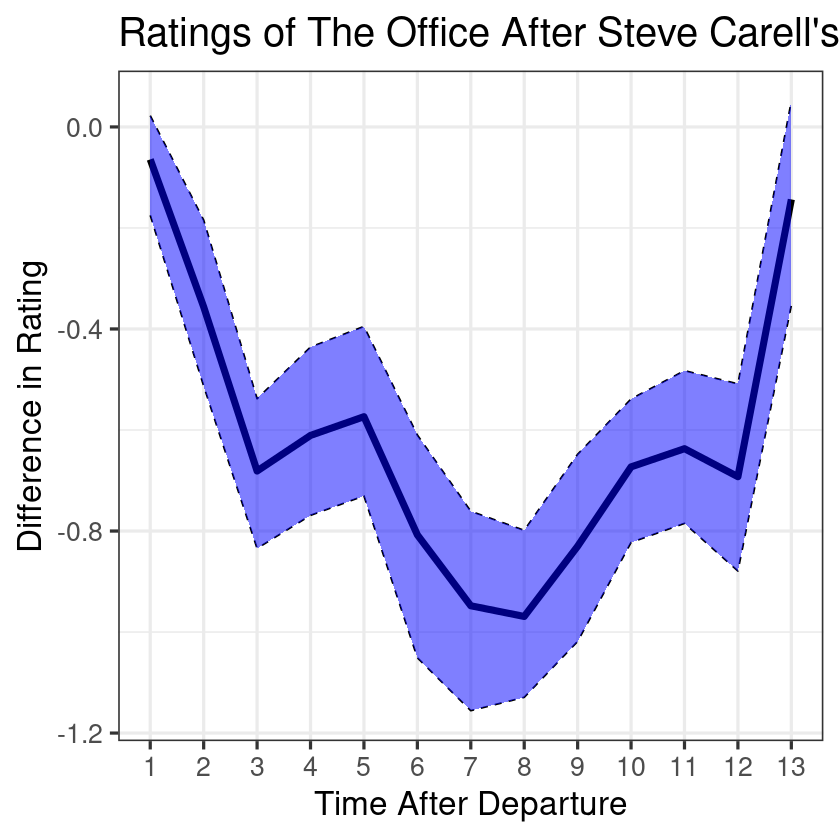

In [642]:
ciExamplePlot

In [17]:
if (!exists("./plotsAndTables")){
    
    dir.create('./plotsAndTables')
    
}

outputDir <- './plotsAndTables'


Warning message in dir.create("./plotsAndTables"):
“'./plotsAndTables' already exists”


In [645]:





ggsave(makeFilename(outputDir, "comedy_panel_example.pdf"), panelDataExample , width=11, height=8.5)


ggsave(makeFilename(outputDir, "group_comparison.pdf"), groupComparisonPlot, width=11, height=8.5)





ggsave(makeFilename(outputDir, "forecast_rmse_plot.pdf"), forecastRMSEPlot, width=11, height=8.5)


ggsave(makeFilename(outputDir, "forecast_rmse_plot_uncertainty.pdf"), forecastRMSEPlotWithUncertainty  , width=11, height=8.5)

fileConn<-file(makeFilename(outputDir, "forecast_estimate_evaluation_ratings.txt"))
writeLines(forecastRMSETableForLatex, fileConn)
close(fileConn)



ggsave(makeFilename(outputDir, "effect_rmse_plot.pdf"), effectRMSEPlot, width=11, height=8.5)


ggsave(makeFilename(outputDir, "effect_rmse_plot_uncertainty.pdf"), effectRMSEPlotWithUncertainty  , width=11, height=8.5)


fileConn<-file(makeFilename(outputDir, "effect_estimate_evaluation_ratings.txt"))
writeLines(effectRMSETableForLatex, fileConn)
close(fileConn)



if (exists("confidenceDataFrameLatex")){

    fileConn<-file(makeFilename(outputDir, "estimated_ratings_ci_coverage.txt"))
    writeLines(confidenceDataFrameLatex, fileConn)
    close(fileConn)
    
    ggsave(makeFilename(outputDir, "ci_example_office.pdf"), ciExamplePlot, width=11, height=8.5)
}

ggsave(makeFilename(outputDir, "ci_example_office.pdf"), ciExamplePlot, width=11, height=8.5)



`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

